In [147]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [148]:
dataset = MNIST(root='data/',
                download=True,
                transform=ToTensor())

In [149]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [150]:
batch_size = 128

train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Img Shape: torch.Size([128, 1, 28, 28])


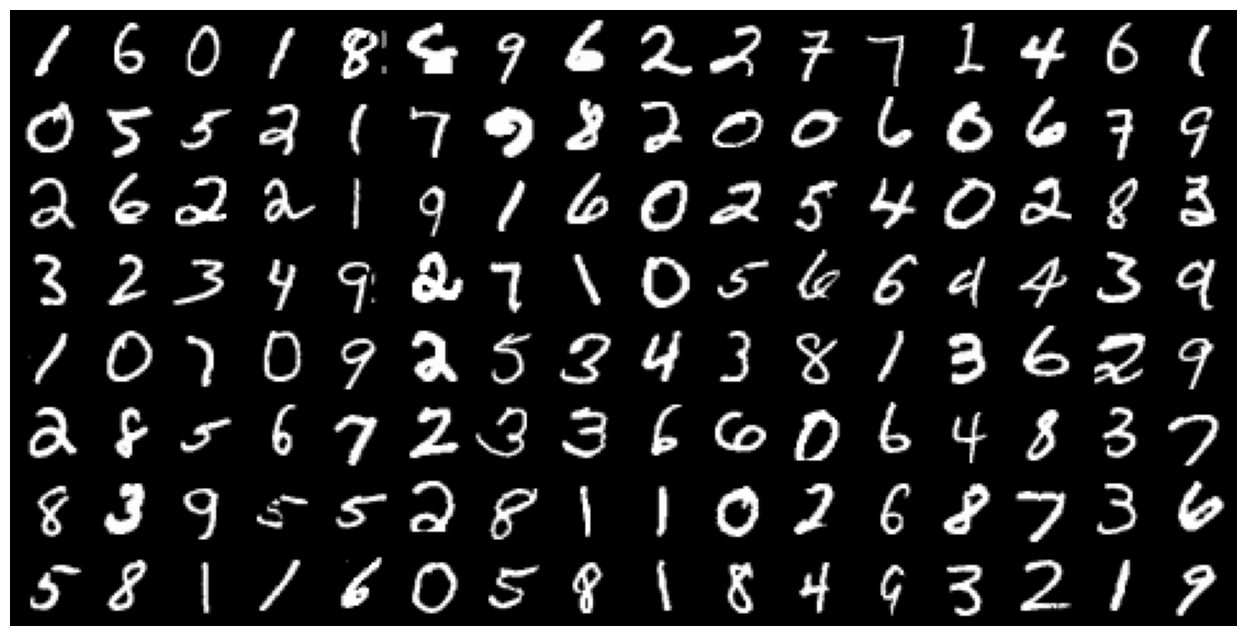

In [151]:
for images,_ in train_loader:
  print("Img Shape:",images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  break

In [152]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [153]:
class MNISTMODEL(nn.Module):
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size,hidden_size)
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    xb = xb.view(xb.size(0),-1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {"Val_loss":loss.detach(),"Val_ACC":acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['Val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['Val_ACC'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"Val_loss":epoch_loss.item(),"Val_ACC":epoch_acc.item()}

  def epoch_end(self,epoch,res1):
    print("Epoch [{}], val_loss:{:.4f}, val_acc: {:.4f}".format(epoch,res1["Val_loss"],res1['Val_ACC']))

In [154]:
in_size = 784
hidden_size = 32
num_classes = 10

In [155]:
model = MNISTMODEL(in_size,hidden_size,out_size=num_classes)

In [156]:
for param in model.parameters():
  print(param.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [157]:
model

MNISTMODEL(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [158]:
for img,labels in train_loader:
  outs = model(img)
  loss = F.cross_entropy(outs,labels)
  print("Loss:{}".format(loss))
  break

Loss:2.2995636463165283


In [159]:
print(outs.shape,outs[:2].data)

torch.Size([128, 10]) tensor([[-0.1410,  0.1680,  0.1415,  0.1312,  0.1534, -0.1675,  0.1208,  0.1505,
          0.0013,  0.0879],
        [-0.1512,  0.0980,  0.1544,  0.1455,  0.1597, -0.1622,  0.1698,  0.2174,
         -0.0405,  0.0855]])


In [160]:
torch.cuda.is_available()

True

In [161]:
def get_dcf_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [162]:
device = get_dcf_device()
device

device(type='cuda')

In [163]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [164]:
for imgs,labels in train_loader:
  print(imgs.shape)
  imgs = to_device(imgs,device)
  print(imgs.device)
  print(imgs)
  break

torch.Size([128, 1, 28, 28])
cuda:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [165]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [166]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

In [167]:
for x,y in val_loader:
  print(x.device)
  print(y)
  break

cuda:0
tensor([5, 3, 2, 3, 5, 9, 2, 6, 3, 1, 2, 7, 4, 4, 4, 1, 6, 9, 2, 0, 7, 0, 5, 7,
        7, 2, 6, 9, 6, 9, 5, 8, 7, 1, 0, 7, 4, 8, 2, 3, 4, 6, 1, 6, 2, 1, 7, 9,
        8, 0, 1, 2, 0, 1, 3, 0, 6, 1, 9, 9, 4, 2, 1, 0, 3, 0, 3, 9, 7, 2, 6, 8,
        9, 0, 3, 2, 1, 4, 9, 6, 9, 9, 8, 0, 0, 4, 9, 9, 0, 4, 8, 9, 6, 7, 7, 2,
        1, 9, 4, 1, 2, 1, 2, 1, 2, 2, 6, 8, 5, 6, 5, 6, 7, 1, 2, 0, 1, 0, 6, 1,
        4, 5, 1, 5, 4, 7, 9, 4, 9, 0, 5, 6, 6, 2, 9, 4, 3, 3, 4, 2, 6, 7, 9, 7,
        4, 1, 7, 2, 6, 1, 5, 9, 8, 9, 8, 0, 2, 3, 3, 5, 3, 8, 9, 6, 2, 9, 0, 7,
        3, 2, 5, 0, 0, 2, 9, 3, 8, 4, 2, 6, 3, 1, 1, 5, 6, 7, 4, 8, 6, 4, 8, 3,
        5, 8, 9, 2, 6, 5, 4, 0, 8, 7, 7, 6, 5, 9, 8, 6, 4, 0, 9, 5, 2, 2, 3, 9,
        7, 3, 5, 9, 6, 2, 0, 4, 8, 9, 9, 0, 3, 3, 1, 8, 6, 1, 3, 1, 0, 1, 3, 0,
        5, 0, 6, 9, 6, 3, 3, 4, 6, 1, 2, 8, 5, 0, 3, 0], device='cuda:0')


In [168]:
def evaluate(model,val_loader):
  outs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outs)

def fit(epochs,lr,model,train_loader,val_loader,opt=torch.optim.SGD):
  history = []
  optimizer = opt(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [169]:
model = MNISTMODEL(in_size,hidden_size,num_classes)
to_device(model,device)

MNISTMODEL(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [170]:
history = [evaluate(model,val_loader)]
history

[{'Val_loss': 2.3289191722869873, 'Val_ACC': 0.07568359375}]

In [171]:
history += fit(5,0.5,model,train_loader,val_loader)

Epoch [0], val_loss:0.2198, val_acc: 0.9374
Epoch [1], val_loss:0.1863, val_acc: 0.9456
Epoch [2], val_loss:0.1907, val_acc: 0.9422
Epoch [3], val_loss:0.1392, val_acc: 0.9575
Epoch [4], val_loss:0.1309, val_acc: 0.9624


In [172]:
history += fit(5,0.1,model,train_loader,val_loader)

Epoch [0], val_loss:0.1192, val_acc: 0.9650
Epoch [1], val_loss:0.1177, val_acc: 0.9669
Epoch [2], val_loss:0.1177, val_acc: 0.9664
Epoch [3], val_loss:0.1152, val_acc: 0.9665
Epoch [4], val_loss:0.1155, val_acc: 0.9669


Text(0.5, 1.0, 'loss vs epoch')

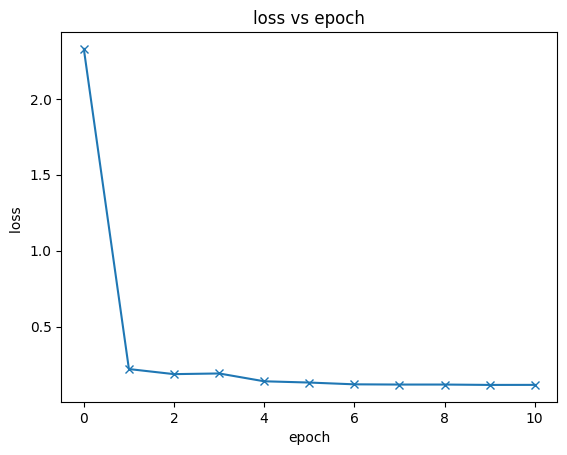

In [174]:
losses = [x['Val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss ')
plt.title("loss vs epoch")

Text(0.5, 1.0, 'acc vs epoch')

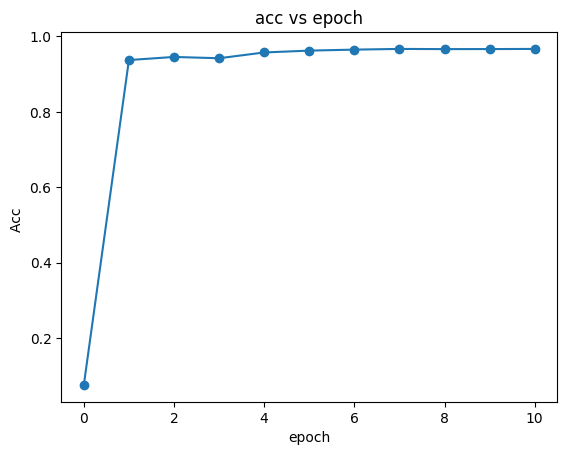

In [175]:
losses = [x['Val_ACC'] for x in history]
plt.plot(losses,'-o')
plt.xlabel('epoch')
plt.ylabel('Acc ')
plt.title("acc vs epoch")